# Demo - The Role of Eccentricity
This demo uses ``LEGWORK`` to illustrate the role of eccentricity in the detectability of a gravitational wave source in LISA.

In [1]:
%matplotlib inline

In [2]:
import legwork as lw
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

## How does eccentricity affect the detectability of a source?
### Demonstration of trends with LEGWORK

Eccentricity plays a complex role in the detection of LISA sources. Although eccentric binaries emit stronger gravitational waves, they also shift the emission to higher frequency harmonics and cause a faster inspiral. These effects in tandem produce some interesting trends that we can demonstrate with ``LEGWORK``.

Let's create three toy sources with different eccentricities and see how their eccentricities change.

In [4]:
# set eccentricities
ecc = np.array([1e-6, 0.6, 0.9])
n_binaries = len(ecc)

# use constant values for mass, f_orb and distance
m_1 = np.repeat(0.6, n_binaries) * u.Msun
m_2 = np.repeat(0.6, n_binaries) * u.Msun
f_orb = np.repeat(1.5e-3, n_binaries) * u.Hz
dist = np.repeat(15, n_binaries) * u.kpc

# get the SNR in each harmonic
snr2_n = lw.snr.snr_ecc_evolving(m_1=m_1, m_2=m_2, f_orb_i=f_orb, ecc=ecc, dist=dist,
                                 harmonics_required=100, t_obs=4 * u.yr, n_step=1000,
                                 ret_snr2_by_harmonic=True)

snr = snr2_n.sum(axis=1)**(0.5)
print(snr)

[31.73932899 50.18790614 38.77725186]


We can see from this that increasing the eccentricity does not always increase the SNR. This can be better understood by plotting the SNR of each harmonic of each source and seeing how the distribution shifts.

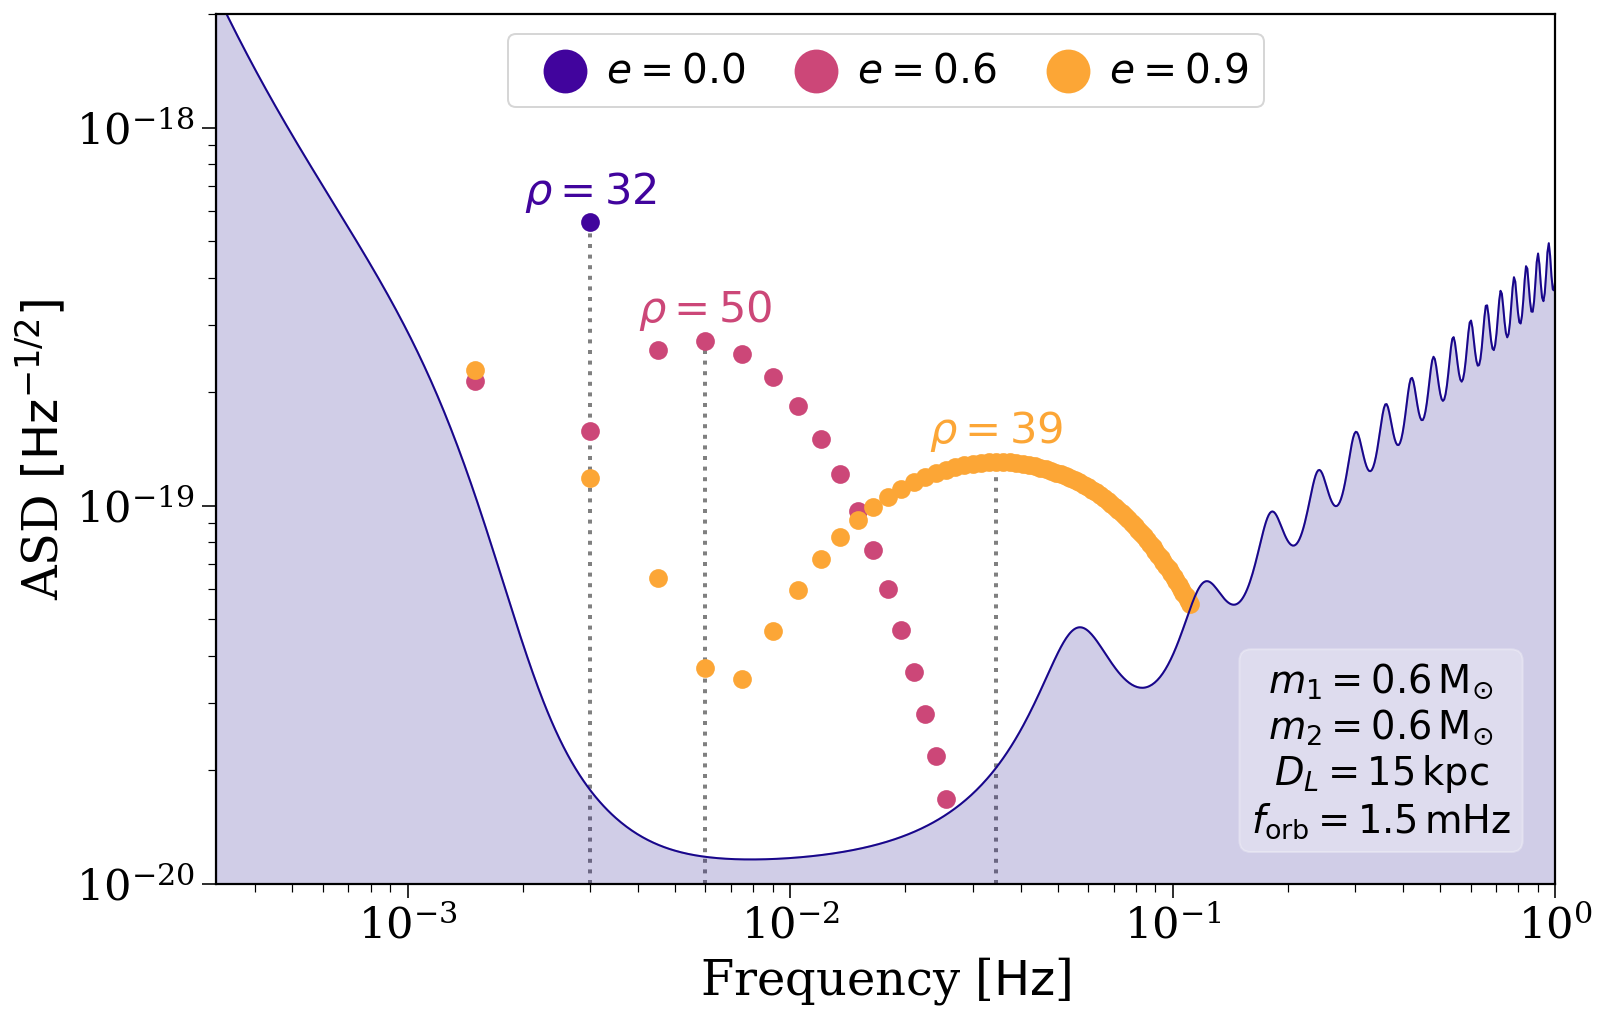

In [5]:
# plot LISA sensitivity curve
fig, ax = lw.visualisation.plot_sensitivity_curve(frequency_range=np.logspace(-3.5, 0, 1000) * u.Hz,
                                                  show=False)

# plot each sources
colours = [plt.get_cmap("plasma")(i) for i in [0.1, 0.5, 0.8]]
for i in range(len(snr2_n)):
    # work out the harmonic frequencies and ASDs
    f_harm = f_orb[i] * range(1, len(snr2_n[0]) + 1)
    y_vals = lw.psd.lisa_psd(f_harm)**(0.5) * np.sqrt(snr2_n)[i]
    
    # only plot points above the sensitivity curve
    mask = np.sqrt(snr2_n)[i] > 1.0
    
    # compute the index of the maximal SNR value
    max_index = np.argmax(y_vals[1:]) + 1
    
    # plot each harmonic
    ax.scatter(f_harm[mask], y_vals[mask],
               s=70, color=colours[i],
               label=r"$e={{{:1.1f}}}$".format(ecc[i]))
    
    # annotate each source with its SNR at the max SNR value
    ax.annotate(r"$\rho={{{:1.0f}}}$".format(snr2_n[i].sum()**(0.5)),
                xy=(f_harm[max_index].value, y_vals[max_index].value * 1.05),
                ha="center", va="bottom", fontsize=0.9*fs, color=colours[i])
    # plot a dotted line to highlight where the signal is concentrated
    ax.plot([f_harm[max_index].value] * 2, [1e-20, y_vals[max_index].value],
               color="grey", linestyle="dotted", lw=2, zorder=0)

# add a legend and annotate the other source properties
ax.legend(markerscale=2.5, handletextpad=0.0, ncol=3, loc="upper center",
          columnspacing=0.75, fontsize=0.85 * fs)

annotation_string = r"$m_1 = 0.6 \, {\rm M_{\odot}}$"
annotation_string += "\n"
annotation_string += r"$m_2 = 0.6 \, {\rm M_{\odot}}$"
annotation_string += "\n"
annotation_string += r"$D_L = 15 \, {\rm kpc}$"
annotation_string += "\n"
annotation_string += r"$f_{\rm orb} = 1.5 \, {\rm mHz}$"

ax.annotate(annotation_string, xy=(3.5e-1, 1.3e-20), ha="center", va="bottom", fontsize=0.8 * fs,
            bbox=dict(boxstyle="round", fc="white", ec="white", alpha=0.3))
    
ax.set_ylim(1e-20, 2e-18)

plt.show()

### Explanation of the trends
We see two effects in the signal-to-noise ratio here. First, increasing the eccentricity from essentially circular to $e = 0.6$ results in a higher signal-to-noise ratio ($\rho=31.7 \to \rho=50.2$). This is because an eccentric binary has enhanced energy emission via gravitational waves. This means that an eccentric binary will not only inspiral faster than an otherwise identical circular binary, but also will always have a stronger gravitational wave strain.

The second effect is more intriguing. We see that increasing the eccentricity from $e = 0.6$ to $e = 0.9$ results in a relative *decrease* in SNR ($\rho=50.2 \to \rho=38.8$). The reason for this is that eccentric binaries emit gravitational waves at many harmonic frequencies (unlike circular binaries, which emit predominantly twice the orbital frequency). This leads to the gravitational wave signal being diluted over many frequencies higher than the orbital frequency, where the higher the eccentricity, the more harmonics are required to capture all of the gravitational luminosity. Therefore, if the eccentricity is too high, the majority of the signal may be emitted at a frequency to which LISA is less sensitive.

From the plot, we can better understand why a source with $e = 0.9$ has a lower SNR than the same source with $e = 0.6$. From the dotted lines, we can note that the signal from the $e = 0.9$ source is concentrated at a frequency of around $4 \times 10^{-2} \, {\rm Hz}$. The LISA sensitivity at this point is much weaker than the $6 \times 10^{-3} \, {\rm Hz}$ at which the $e =0.6$ source is concentrated. Therefore, although the strain from a more eccentric binary is stronger, the SNR is lower due to the increased noise in the LISA detector.

Overall, we can therefore conclude that for LISA sources of this nature, higher eccentricity will produce more detectable binaries only if the orbital frequency is not already at or above the minimum of the LISA sensitivity curve. Another consideration for more massive binaries is whether the increased eccentricity will cause the binary to merge before the mission ends, which would cause a significant decrease in signal-to-noise ratio.

## How does eccentricity affect the merger time?

As mentioned above, eccentric binaries will merge more quickly than circular ones and we can show this with ``LEGWORK``.

Below, we make a grid of frequencies and eccentricities, flatten them and calculate their merger times, before reshaping and plotting the result.

In [6]:
f_range = np.logspace(-5, -1, 100) * u.Hz
e_range = np.linspace(0, 0.99, 500)

m_1 = np.repeat(10, len(f_range) * len(e_range)) * u.Msun
m_2 = np.repeat(10, len(f_range) * len(e_range)) * u.Msun

F, E = np.meshgrid(f_range, e_range)

t_merge = lw.evol.get_t_merge_ecc(ecc_i=E.flatten(), f_orb_i=F.flatten(), m_1=m_1, m_2=m_2).reshape(F.shape)

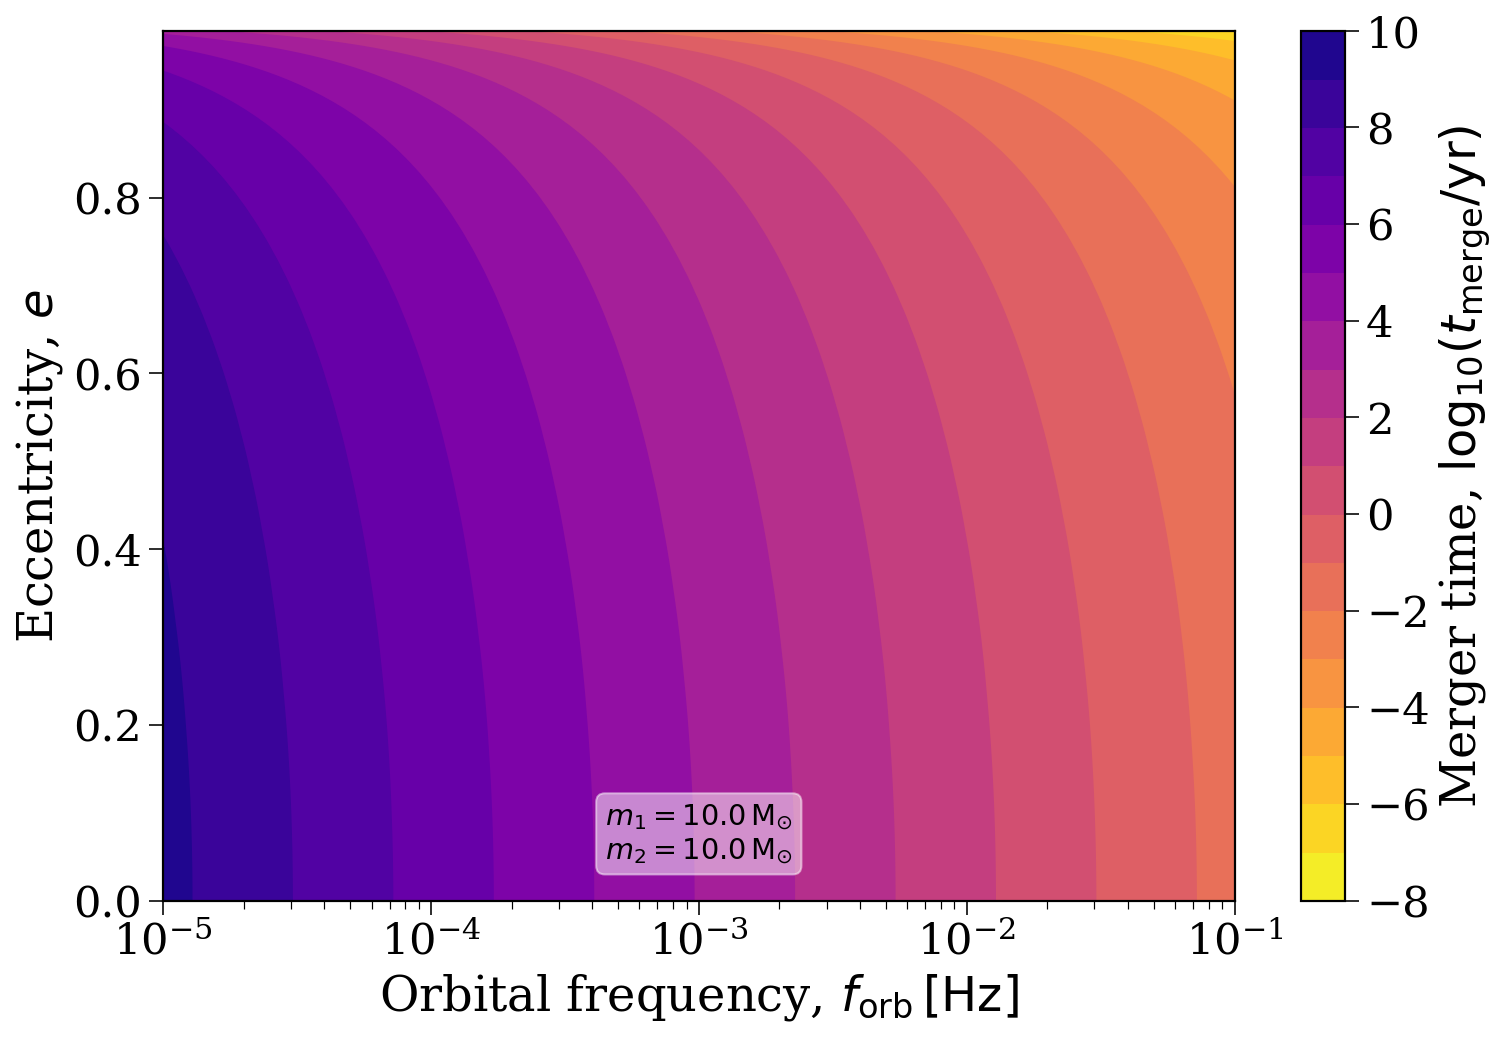

In [8]:
fig, ax = plt.subplots()

cont = ax.contourf(F, E, np.log10(t_merge.to(u.yr).value), cmap="plasma_r", levels=np.linspace(-8, 10, 19))
cbar = fig.colorbar(cont, label=r"Merger time, $\log_{10} (t_{\rm merge} / {\rm yr})$")
ax.set_xscale("log")

# hide edges that show up in rendered PDFs
for c in cont.collections:
    c.set_edgecolor("face")

mass_string = ""
mass_string += r"$m_1 = {{{}}} \, {{ \rm M_{{\odot}}}}$".format(m_1[0].value)
mass_string += "\n"
mass_string += r"$m_2 = {{{}}} \, {{ \rm M_{{\odot}}}}$".format(m_2[0].value)
ax.annotate(mass_string, xy=(0.5, 0.04), xycoords="axes fraction", fontsize=0.6*fs,
            bbox=dict(boxstyle="round", color="white", ec="white", alpha=0.5), ha="center", va="bottom")

ax.set_xlabel(r"Orbital frequency, $f_{\rm orb} \, [\rm Hz]$")
ax.set_ylabel(r"Eccentricity, $e$")

plt.show()